# Election-bots: A Twitter Propaganda Machine
## Results

This notebook outlines the code used to estimate the results of the research project _Election-bots: A Twitter Propaganda Machine_. It contains descriptive statistics of the sample, word frequency distributions, a probabilistic topic model analysis and discursive influence measures.


In [1]:
#load libraries
import lucem_illud_2020 as lucem
import pandas as pd
from pandas.plotting import table
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import seaborn
import sklearn
import spacy
import graphviz
import os.path
import wordcloud
import nltk
import gensim
import rope
from dit import Distribution
from dit.divergences import jensen_shannon_divergence


In [2]:
# load data
days = pd.read_csv(r'.\Classified\all.csv')
days = days.reset_index().drop(['index','Unnamed: 0'], axis=1)
days.shape

(335299, 22)

I classified the sample of 335299 tweets assigning each account a complete automation probability (CAP), using the Botometer API. 

In [91]:
# get unique accounts
accounts = days.drop_duplicates('user_id')
accounts.shape

(82298, 25)

The CAP ranges from 0 to 1. A histogram of CAP values in our sample can help us determine the appropiate cutoff point that distinguishes between bot and user accounts.

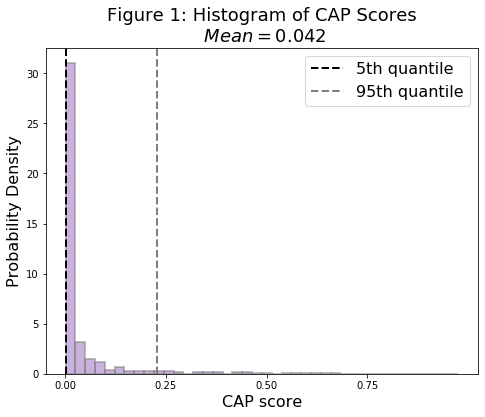

In [97]:
#%% get quantiles
quant_5 = accounts['cap'].quantile(.05)
quant_95 = accounts['cap'].quantile(.95)

#%% create a histogram of caps
num_bins = 40
mu_cap = accounts['cap'].mean()
plt.figure( figsize=(8,6))
n, bins, patches = plt.hist(accounts['cap'], 
                            num_bins, 
                            density=1, 
                            facecolor='tab:purple', 
                            alpha=0.5,
                            edgecolor='grey',
                            linewidth=2)
plt.axvline(quant_5,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='5th quantile')
plt.axvline(quant_95,ymin=0,ymax=1,linestyle='dashed',c='tab:grey',
            linewidth=2, label='95th quantile')
plt.xticks(np.arange(0, 1, .25))
plt.xlabel('CAP score',
           fontsize=16)
plt.ylabel('Probability Density',
           fontsize=16)
plt.title('Figure 1: Histogram of CAP Scores\n $Mean=0.042$',
          fontsize=18)
plt.legend(loc='best', prop={'size':16})
plt.subplots_adjust(left=0.15)
plt.savefig('hist_CAP.png', format = 'png', bbox_inches='tight')

A majority of the sample consists of accounts with very low CAP probabilities. This is due to the fact that the Botomoter algorithm is designed to minimize false positives. Different use cases of the algorithm have determined the appropiate threshold to minimize the missclassification error rate to be around 0.43. I will be using this threshold as well as a comparison of the top and bottom quantiles of the CAP distribution. 

In [3]:
#create labels for bot accounts above .043 CAP score
days['type'] = ['bot' if x > .43 else "user" for x in days['cap']]
days['type_n'] = [1 if x > .43 else 0 for x in days['cap']]

In [4]:
#filter the bot content
bots = days[days['type']=='bot']

# filter the user content
users = days[days['type']=='user']

In [7]:
#find the number of posts by user vs. nunmber of posts by bot
bot_post_user = pd.DataFrame(days['type'].value_counts()).reset_index()
bot_post_user = bot_post_user.rename(columns={"index":"Account Type",
                                          "type":"# of Posts"})
bot_post_user

,Account Type,# of Posts
0,user,321269
1,bot,14030


In [8]:
#number of bots vs users
bot_num_user = days.drop_duplicates(subset='user_id')['type'].value_counts()
bot_num_user = pd.DataFrame(bot_num_user).reset_index()
bot_num_user = bot_num_user.rename(columns={"index":"Account Type",
                                          "type":"# of Accounts"})
bot_num_user

,Account Type,# of Accounts
0,user,80561
1,bot,1737


In [9]:
#calculate...
#proportion of bot  and user accounts in sample
bot_proportion = days.drop_duplicates(subset='user_id')['type_n'].mean()
user_proportion = 1-bot_proportion
#proportion of posts from bot and user accounts in sample
bot_post_proportion = np.mean(days['type_n'])
user_post_proportion = 1-bot_post_proportion
#proportion of retweets by users and bots
prop_retweets_bot = days[days['is_retweet']==True]['type_n'].mean()
prop_retweets_user = 1 - prop_retweets_bot
#number of retweets by users and bots
num_retweets = days.groupby(['type'])['is_retweet'].sum()
#proportion of tweets by users and bots
prop_tweets_bot = days[days['is_retweet']==False]['type_n'].mean()
prop_tweets_user = 1 - prop_tweets_bot
#number of tweets by user and bots
num_tweets_bot = days[days['is_retweet']==False]['type_n'].sum()
num_tweets_user = days[days['is_retweet']==False]['type_n'].count() - num_tweets_bot

print(bot_proportion,user_proportion,bot_post_proportion,
     user_post_proportion,prop_retweets_user,num_retweets,
     prop_tweets_bot,prop_tweets_user, num_tweets_bot,num_tweets_user)

0.021106223723541276 0.9788937762764587 0.0418432503526703 0.9581567496473297 0.9524573685788351 type
bot      13480.0
user    270055.0
Name: is_retweet, dtype: float64 0.010625144888339386 0.9893748551116606 550 51214


In [10]:
#combine all estimates into a dataframe, starting with number of accounts by type
bot_vs_user = bot_num_user
#add the number of accounts as a percentage
bot_vs_user['# of Accounts (Percent)'] = [round(user_proportion,3),
                                           round(bot_proportion,3)]
bot_vs_user['# of Accounts (Percent)'] = bot_vs_user['# of Accounts (Percent)'].mul(100)
bot_vs_user['# of Accounts (Percent)'] = bot_vs_user['# of Accounts (Percent)'].round(3).astype(str).add('%')
#merge the number of posts by type of account
bot_vs_user = pd.merge(bot_vs_user,bot_post_user,how='left',on='Account Type')
#add the number of posts as a percentage
bot_vs_user['# of Posts (Percent)'] = [round(user_post_proportion,3),
                                         round(bot_post_proportion,3)]
bot_vs_user['# of Posts (Percent)'] = bot_vs_user['# of Posts (Percent)'].mul(100).astype(str).add('%')
#add the number of tweets
bot_vs_user['# of Tweets']=[num_tweets_user, num_tweets_bot]
#add the number of tweets as a percentage
bot_vs_user['# of Tweets (Percent)']=[prop_tweets_user,prop_tweets_bot]
bot_vs_user['# of Tweets (Percent)']= bot_vs_user['# of Tweets (Percent)'].mul(100).round(1).astype(str).add('%')
#add the number of retweets
bot_vs_user['# of Retweets']=[num_retweets[1], num_retweets[0]]
#add the number of retweets as a percentage
bot_vs_user['# of Retweets (Percent)']=[prop_retweets_user,prop_retweets_bot]
bot_vs_user['# of Retweets (Percent)']= bot_vs_user['# of Retweets (Percent)'].mul(100).round(1).astype(str).add('%')


In [11]:
#average number of posts comparison
avg_posts = days.groupby(['user_id','type'])['type'].count().groupby('type').mean()
bot_vs_user["Average Posts (Per Account)"] = [round(avg_posts[1],2),
                                                round(avg_posts[0],2)]

#average number of retweets comparison
avg_retweets = days.groupby(['user_id','type'])['is_retweet'].sum().groupby('type').mean()

#average number of tweets comparison
avg_tweets = avg_posts - avg_retweets

#add values to dataframe
bot_vs_user["Average Tweets (Per Account)"]=[round(avg_tweets[1],2),
                                                round(avg_tweets[0],2)]
bot_vs_user["Average Retweets (Per Account)"]=[round(avg_retweets[1],2),
                                                round(avg_retweets[0],2)]

In [12]:
# re-organize dataframe into a table
bot_vs_user = bot_vs_user.T
bot_vs_user.columns = bot_vs_user.iloc[0]
bot_vs_user = bot_vs_user[bot_vs_user['user']!='user']

In [13]:
bot_vs_user

Account Type,user,bot
# of Accounts,80561,1737
# of Accounts (Percent),97.9%,2.1%
# of Posts,321269,14030
# of Posts (Percent),95.8%,4.2%
# of Tweets,51214,550
# of Tweets (Percent),98.9%,1.1%
# of Retweets,270055,13480
# of Retweets (Percent),95.2%,4.8%
Average Posts (Per Account),3.97,6.78
Average Tweets (Per Account),0.63,0.27


The above table shows how even though only a small part of the accounts on Twitter are bots (4.8%), these accounts are responsible for more than 9% of the overall content. These accounts are also highly active in terms of retweets (6.37 per account, on average), compared to original tweets (0.27 per account, on average). 

In [13]:
# identify the top quartile of the CAP distribution
fake_users = bots[bots['cap'] > .75]

fake_users.shape

(870, 25)

In [44]:
#create a proportional dataframe for users at the bottom of the CAP distribution

quant_1 = accounts['cap'].quantile(.01)
low_cap = users[users['cap'] < quant_1]
low_cap.shape

(849, 24)

In [30]:
#normalizing text data for fake users
fake_users['tokenized_text'] = fake_users['text'].apply(lambda x: lucem.word_tokenize(x))
fake_users['normalized_text'] = fake_users['tokenized_text'].apply(lambda x: lucem.normalizeTokens(x,
                                                                                                   extra_stop=['>',
                                                                                                               '<',
                                                                                                               'u+0001f1fa><u+0001f1f8',
                                                                                                               'amp'])) 
 
    

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#normalizing text data for users
low_cap['tokenized_text'] = low_cap['text'].apply(lambda x: lucem.word_tokenize(x))
low_cap['normalized_text'] = low_cap['tokenized_text'].apply(lambda x: lucem.normalizeTokens(x,
                                                                                             extra_stop=['>',
                                                                                                         '<',
                                                                                                         'u+0001f1fa><u+0001f1f8]',
                                                                                                         'amp']))


C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
#counting top words for bots
fake_countsDict = {}
for word in fake_users['normalized_text'].sum():
    if word in fake_countsDict:
        fake_countsDict[word] += 1
    else:
        fake_countsDict[word] = 1
fake_word_counts = sorted(fake_countsDict.items(), key = lambda x : x[1], reverse = True)

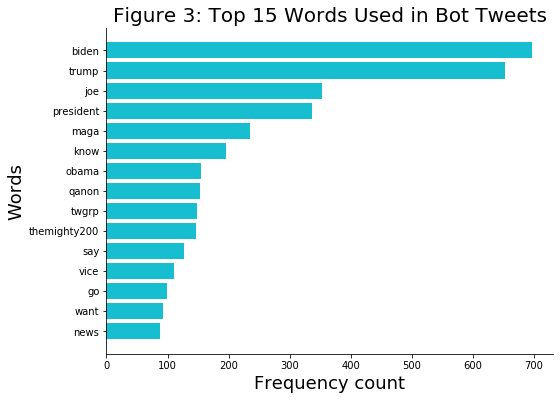

In [33]:
#plotting the top bot words
fake_wordCounts = pd.DataFrame(fake_word_counts,columns=['words','count'])
#bot_wordCounts.to_csv(r'.\Word_counts\bot_wc.csv')
top_botWords = fake_wordCounts.iloc[:15,:]
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_botWords['words'],top_botWords['count'],
        facecolor='tab:cyan')
ax.set_title('Figure 3: Top 15 Words Used in Bot Tweets',
            fontsize=20)
ax.set_ylabel('Words',
             fontsize=18)
ax.set_xlabel('Frequency count',
             fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_wordcount.png", format = 'png', bbox_inches='tight')

In [34]:
#counting top words for low-CAP users
lowcap_countsDict = {}
for word in low_cap['normalized_text'].sum():
    if word in lowcap_countsDict:
        lowcap_countsDict[word] += 1
    else:
        lowcap_countsDict[word] = 1
lowcap_word_counts = sorted(lowcap_countsDict.items(), key = lambda x : x[1], reverse = True)

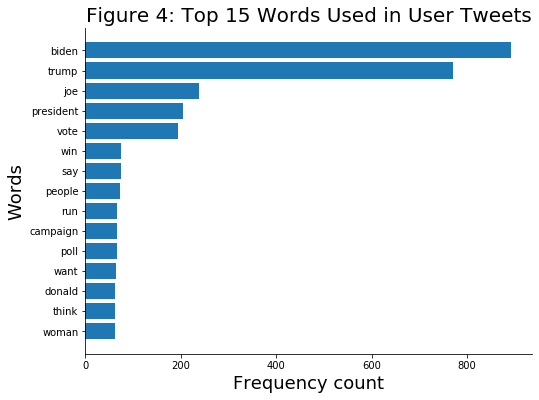

In [35]:
#plotting the top user words
user_wordCounts = pd.DataFrame(lowcap_word_counts,columns=['words','count'])
#user_wordCounts.to_csv(r'.\Word_counts\user_wc.csv')
top_userWords = user_wordCounts.iloc[:15,:]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_userWords['words'],top_userWords['count'],
        facecolor='tab:blue')
ax.set_title('Figure 4: Top 15 Words Used in User Tweets',
            fontsize=20)
ax.set_ylabel('Words',
             fontsize=18)
ax.set_xlabel('Frequency count',
             fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_wordcount.png", format = 'png', bbox_inches='tight')

This results make it seem like we're comparing exactly the same type of accounts, but let's dig a little deeper to see if we can undercover semantic differences by using bigrams, trigrams and analysis of POS.

In [36]:
#find the top bigrams for bots
botBigrams = nltk.collocations.BigramCollocationFinder.from_words(fake_users['normalized_text'].sum())
bigram_measures = nltk.collocations.BigramAssocMeasures()
bot_top10_bigrams = botBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]
bot_top10_bigrams = pd.DataFrame(bot_top10_bigrams, columns=['words','score'])
bot_top10_bigrams['words'] = bot_top10_bigrams['words'].apply(lambda x: x[0] + ' ' + x[1])



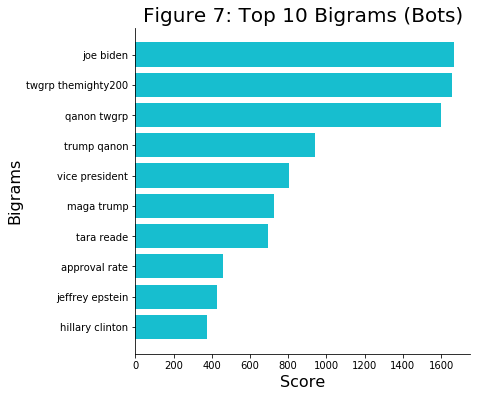

In [45]:
#plot the top bigrams for bots
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(bot_top10_bigrams['words'],bot_top10_bigrams['score'],
        facecolor='tab:cyan')
ax.set_title('Figure 7: Top 10 Bigrams (Bots)',
            fontsize=20)
ax.set_ylabel('Bigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_bigrams.png", format = 'png', bbox_inches='tight')

In [43]:
#find the top bigrams for low-cap users
userBigrams = nltk.collocations.BigramCollocationFinder.from_words(low_cap['normalized_text'].sum())
bigram_measures = nltk.collocations.BigramAssocMeasures()
user_top10_bigrams = userBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]
user_top10_bigrams = pd.DataFrame(user_top10_bigrams, columns=['words','score'])
user_top10_bigrams['words'] = user_top10_bigrams['words'].apply(lambda x: x[0] + ' ' + x[1])



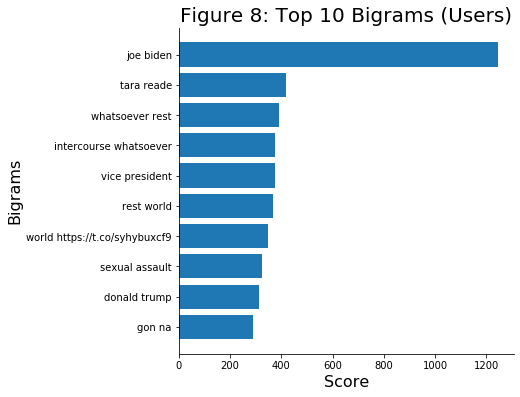

In [46]:
#plotting the top user bigrams
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(user_top10_bigrams['words'],user_top10_bigrams['score'],
        facecolor='tab:blue')
ax.set_title('Figure 8: Top 10 Bigrams (Users)',
            fontsize=20)
ax.set_ylabel('Bigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_bigrams.png", format = 'png', bbox_inches='tight')

In [48]:
#find the top trigrams for bots
botTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(fake_users['normalized_text'].sum())
trigram_measures = nltk.collocations.TrigramAssocMeasures()
bot_top15_trigrams = botTrigrams.score_ngrams(trigram_measures.likelihood_ratio)[:10]
bot_top15_trigrams = pd.DataFrame(bot_top15_trigrams, columns=['words','score'])
bot_top15_trigrams['words'] = bot_top15_trigrams['words'].apply(lambda x: x[0] + ' ' + x[1]+' '+x[2])


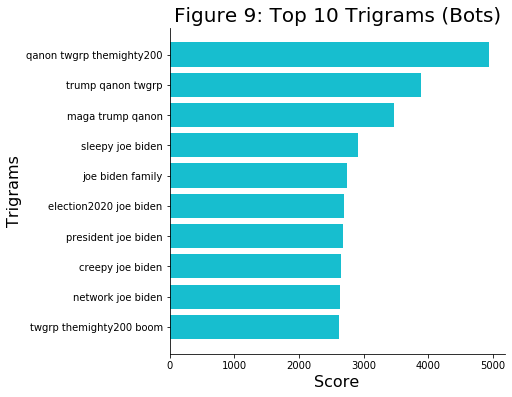

In [51]:
#plotting the top bot trigrams
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(bot_top15_trigrams['words'],bot_top15_trigrams['score'],
        facecolor='tab:cyan')
ax.set_title('Figure 9: Top 10 Trigrams (Bots)',
            fontsize=20)
ax.set_ylabel('Trigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_trigrams.png", format = 'png', bbox_inches='tight')

In [52]:
#find the top bigrams for low-cap users
userTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(low_cap['normalized_text'].sum())
trigram_measures = nltk.collocations.TrigramAssocMeasures()
user_top15_trigrams = userTrigrams.score_ngrams(trigram_measures.likelihood_ratio)[:10]
user_top15_trigrams = pd.DataFrame(user_top15_trigrams, columns=['words','score'])
user_top15_trigrams['words'] = user_top15_trigrams['words'].apply(lambda x: x[0] + ' ' + x[1]+' '+x[2])

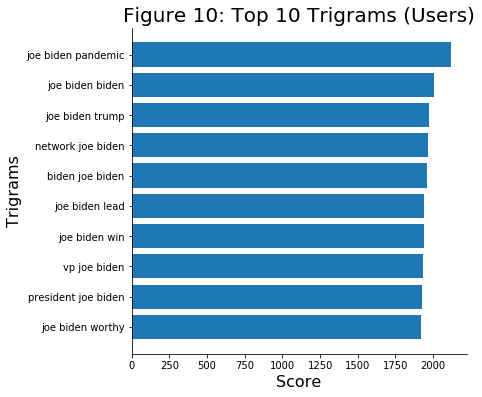

In [54]:
#plotting the top user bigrams
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(user_top15_trigrams['words'],user_top15_trigrams['score'],
        facecolor='tab:blue')
ax.set_title('Figure 10: Top 10 Trigrams (Users)',
            fontsize=20)
ax.set_ylabel('Trigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_trigrams.png", format = 'png', bbox_inches='tight')

If one where to simply look at the top words used by each group (bots vs. users), it would be easy to think that the content was exactly the same. However, by examining the collocations of trigrams and bigrams one can clearly see that the bot conversation has a much different tone towards Joe Biden that the real user conversation.

Now I look at the divergence measures between bot and user word distributions.

In [74]:
#calculate the overlap in words and their porbabilities
word_overlap = pd.merge(fake_wordCounts, user_wordCounts, on='words',how='inner')
word_overlap['bot_probs'] = word_overlap['count_x'] / word_overlap['count_x'].sum()
word_overlap['user_probs'] = word_overlap['count_y'] / word_overlap['count_y'].sum()

In [75]:
#transfrm probabilities into array for efficiency
bot_array = np.array(word_overlap['bot_probs'])
user_array = np.array(word_overlap['user_probs'])

In [76]:
#calculate the K-L divergence
bot_KL = scipy.stats.entropy(bot_array, user_array)
user_KL = scipy.stats.entropy(user_array, bot_array)

In [77]:
#calculate the elemtwise KL divergence for bots
word_overlap['bot_kl_divergence']= scipy.special.kl_div(bot_array, user_array)


In [78]:
#sort values
word_overlap = word_overlap.sort_values(by='bot_kl_divergence', ascending=False)

In [79]:
#Calculate the Jensen-Shannon divergence
bot_vs_userJS = scipy.spatial.distance.jensenshannon(bot_array, user_array)
bot_vs_userJS

0.31722896878413814

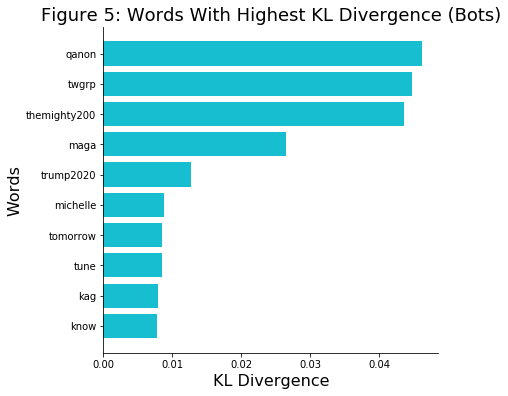

In [82]:
#plot the words from bots with the highest divergence
top10_divergence = word_overlap.iloc[:10,:]
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(top10_divergence['words'],top10_divergence['bot_kl_divergence'],
        facecolor='tab:cyan')
ax.set_title('Figure 5: Words With Highest KL Divergence (Bots)', fontsize=18)
ax.set_ylabel('Words',fontsize=16)
ax.set_xlabel('KL Divergence',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_divergence.png", format = 'png', bbox_inches='tight')

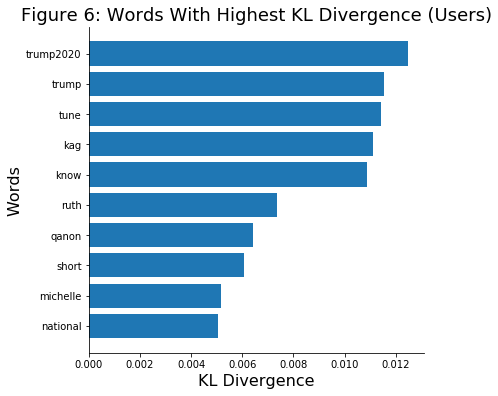

In [83]:
#calculate the elemtwise KL divergence for users
word_overlap['user_kl_divergence']= scipy.special.kl_div(user_array, bot_array)
word_overlap = word_overlap.sort_values(by='user_kl_divergence', ascending=False)
top10_divergence = word_overlap.iloc[:10,:]

#plot the words from users with the highest divergence
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(top10_divergence['words'],top10_divergence['user_kl_divergence'],
        facecolor='tab:blue')
ax.set_title('Figure 6: Words With Highest KL Divergence (Users)', fontsize=18)
ax.set_ylabel('Words',fontsize=16)
ax.set_xlabel('KL Divergence',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_divergence.png", format = 'png', bbox_inches='tight')

Now I take a look at which topics bots are talking about the most. I trained several LDA models and found that the one with the highest coherence score was that which had 14 topics.

In [310]:
#load the 14 topic lda model
from sklearn.externals import joblib 
lda_14 = joblib.load(r'.\LDA\lda_14.pkl') 

#create a dataframe with the words that best identify each topic
topicsDict = {}
for topicNum in range(lda_14.num_topics):
    topicWords = [w for w, p in lda_14.show_topic(topicNum)]
    topicsDict['Topic {}'.format(topicNum)] = topicWords
wordRanks_14 = pd.DataFrame(topicsDict)
wordRanks_14

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
0,reade,flynn,poll,know,like,lie,china,win,joe,maga,woman,obama,president,vote
1,tara,campaign,lead,joe,supporter,oval,key,beat,old,trump2020,rape,anti,joe,party
2,sexual,lawyer,joe,president,look,news,pandemic,need,public,kag,accuse,entire,run,bernie
3,assault,russia,drop,obama,people,donor,coronavirus,want,fuck,president,believe,january,say,people
4,allegation,investigation,point,donald,rapist,like,death,lose,talk,qanon,accuser,white,vice,democrat
5,claim,justice,election,people,democrat,fake,country,think,say,wwg1wga,assault,office,obama,want
6,joe,hoax,test,american,thing,barr,america,debate,force,god,ad,house,endorse,win
7,story,record,new,care,hold,bad,response,pick,let,america,question,presidency,office,november
8,accusation,attack,race,corrupt,support,know,americans,amash,year,obama,allegation,administration,step,think
9,false,pay,state,america,try,want,campaign,vp,video,economy,metoo,die,year,voter


In [24]:
topics_df = pd.read_csv(r'.\LDA\topic_labels.csv')
topics_df.drop('Unnamed: 0', axis=1)

,text,max_topic
0,The Lincoln Movement is a fundraising arm of t...,10
1,Biden is Kristol's pro-war candidate of choice...,12
2,The @TheLincolnPAC is a front group for the Jo...,6
3,The Lincoln Movement is a front for Biden-back...,10
4,@TheLincolnPAC The Lincoln Movement is a front...,10
...,...,...
59238,"Top story: Prominent lawyer, Trump donor repre...",5
59239,Biden's edge evaporates as Trump seen as bette...,13
59240,"Prominent lawyer, Trump donor representing Bid...",5
59241,@marxist_morgan people have their blinders on ...,10


In [22]:
# load data
days = pd.read_csv(r'.\Classified\all.csv')
days = days.reset_index().drop(['index','Unnamed: 0'], axis=1)

#create labels for bot accounts above the a 0.43 CAP score
days['type'] = ['bot' if x > .43 else "user" for x in days['cap']]
days['type_n'] = [1 if x > .43 else 0 for x in days['cap']]


In [25]:
#add topics to the dataframe
days = pd.merge(days, topics_df, on='text', how='outer').drop('Unnamed: 0', axis=1)

In [26]:
days.head(3)

,user_id,status_id,created_at,screen_name,text,is_retweet,favorite_count,retweet_count,hashtags,mentions_screen_name,...,followers_count,friends_count,statuses_count,account_created_at,verified,location,cap,type,type_n,max_topic
0,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.028226,user,0,10
1,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.018904,user,0,10
2,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.028226,user,0,10


In [27]:
#turn 'topics' column into string
days['max_topic'] = days['max_topic'].apply(str)

In [90]:
#calculate number of posts belonging to each topic for the whole set
topic_counts = days.groupby(['max_topic', 'type'])['max_topic'].count()
topic_counts = pd.DataFrame(topic_counts)
topic_counts = topic_counts.rename(columns={'max_topic':'Count'}).reset_index()

#get the proportion of tweets that belong to each topic from each type of account
topic_counts['proportion'] = [topic_counts.iloc[i,2] / bot_post_user.iloc[1,1] 
                              if topic_counts.iloc[i,1] == 'bot' else
                              topic_counts.iloc[i,2] / bot_post_user.iloc[0,1] 
                              for i in range(0,len(topic_counts))]


In [91]:
#turn the proportion into a percent
topic_counts['percent'] = topic_counts.proportion.mul(100).round(2)
topic_counts['max_topic'] = topic_counts['max_topic'].apply(int)
topic_counts.sort_values('max_topic', ascending=True, inplace=True)
topic_counts

,max_topic,type,Count,proportion,percent
0,0,bot,802,0.057163,5.72
1,0,user,26217,0.081605,8.16
2,1,bot,833,0.059373,5.94
3,1,user,17012,0.052953,5.30
12,2,bot,720,0.051319,5.13
13,2,user,26168,0.081452,8.15
14,3,bot,1271,0.090592,9.06
15,3,user,32712,0.101821,10.18
16,4,bot,409,0.029152,2.92
17,4,user,19242,0.059894,5.99


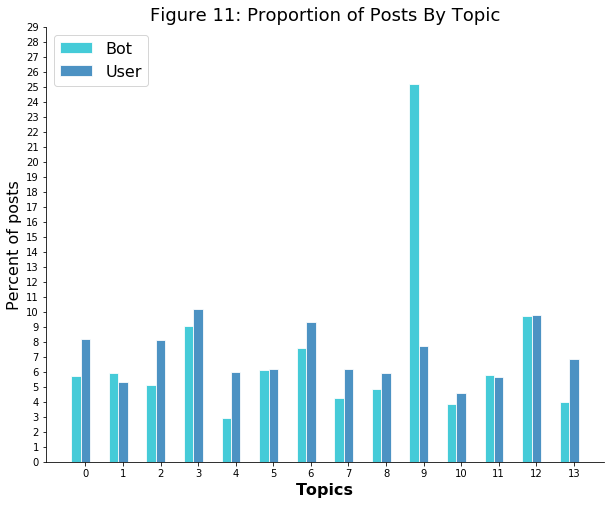

In [93]:
#create a barplot with the percent for each topic
# set width of bar
barWidth = 0.25
 
# set heights of bar
bot = topic_counts[topic_counts['type']=='bot']['percent']
user = topic_counts[topic_counts['type']=='user']['percent']
topics = topic_counts.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(10,8))
 
# Make the plot
ax.bar(r1, bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Percent of posts', fontsize=16)
plt.title('Figure 11: Proportion of Posts By Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
plt.legend(loc='upper left', fontsize=16)
plt.savefig("percent_topics.png", format = 'png', bbox_inches='tight')


In [61]:
#load influence data
three_hour = pd.read_csv(r'.\Scores\three_hour.csv').drop(['Unnamed: 0'], axis=1)
twenty_minute = pd.read_csv(r'.\Scores\five_min.csv').drop(['Unnamed: 0'], axis=1)


In [62]:
three_hour = three_hour[['status_id', 'novelty','transience','resonance']]
three_hour = three_hour.rename(columns={'novelty':'nov_3hour', 'transience':'trans_3hour','resonance':'res_3hour'})
twenty_minute = twenty_minute[['status_id', 'novelty','transience','resonance']]
twenty_minute = twenty_minute.rename(columns={'novelty':'nov_20min', 'transience':'trans_20min','resonance':'res_20min'})

scores = pd.merge(three_hour,twenty_minute,on="status_id",how='outer')

In [65]:
#filter bot content for those with high CAP
fake_users = days[days['cap'] > .75]
fake_users = pd.merge(fake_users,scores,on="status_id",how='left')
fake_users.shape


(884, 31)

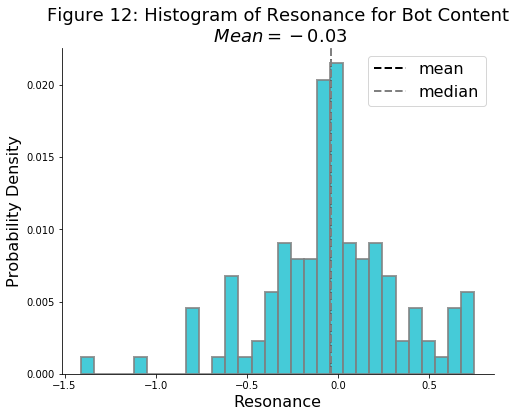

In [129]:
# plot histogram of resonance measures for bots
num_bins = 30
mu = fake_users['res_3hour'].mean()
median = fake_users['res_3hour'].median()
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = plt.hist(fake_users['res_3hour'], 
                            num_bins, 
                            weights=np.ones(len(fake_users['res_3hour'])) / len(fake_users['res_3hour']), 
                            facecolor='tab:cyan', 
                            alpha=.8,
                            edgecolor='grey',
                            linewidth=2)
plt.axvline(mu,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='mean')
plt.axvline(median,ymin=0,ymax=1,linestyle='dashed', c='grey',
            linewidth=2, label='median')
plt.xlabel('Resonance',
          fontsize=16)
plt.ylabel('Probability Density',
          fontsize=16)
plt.title('Figure 12: Histogram of Resonance for Bot Content\n $Mean=-0.03$',
         fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc='best', fontsize=16)
plt.savefig('hist_bot_resonance.png', format = 'png', bbox_inches='tight')

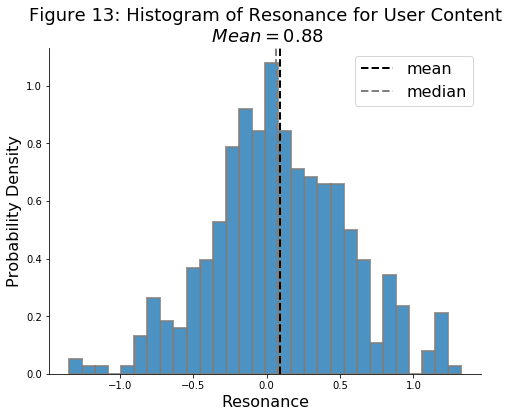

In [128]:
# plot histogram of resonance measures for users
num_bins = 30
mu = low_cap['res_3hour'].mean()
median = low_cap['res_3hour'].median()
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = plt.hist(low_cap['res_3hour'], 
                            num_bins, 
                            density=True, 
                            facecolor='tab:blue',
                            edgecolor='grey',
                            alpha=.8,
                            linewidth=2)
plt.axvline(mu,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='mean')
plt.axvline(median,ymin=0,ymax=1,linestyle='dashed', c='grey',
            linewidth=2, label='median')
plt.xlabel('Resonance',
          fontsize=16)
plt.ylabel('Probability Density',
          fontsize=16)
plt.title('Figure 13: Histogram of Resonance for User Content\n $Mean=0.88$',
         fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc='best', fontsize=16)
plt.savefig('hist_user_resonance.png', format = 'png', bbox_inches='tight')

In [112]:
mu

0.08815000728509105

In [66]:
#filter user content for those with low CAP
low_cap = days[days['cap'] < quant_1]
low_cap = pd.merge(low_cap,scores,on="status_id",how='left')
low_cap.shape

(935, 31)

In [67]:
comparison_group = pd.concat([fake_users,low_cap])
comparison_group['max_topic'].head(5)

0    11
1     8
2     6
3     6
4     6
Name: max_topic, dtype: object

In [68]:
comparison_group.sort_values('res_3hour', ascending=False, inplace=True)


In [69]:
comparison_group.shape

(1819, 31)

In [70]:
comparison_group[comparison_group['type']=='bot'].count()

user_id                    884
status_id                  884
created_at                 884
screen_name                884
text                       884
is_retweet                 884
favorite_count             884
retweet_count              884
hashtags                   194
mentions_screen_name       782
retweet_favorite_count     752
retweet_followers_count    752
retweet_friends_count      752
retweet_verified           752
description                714
followers_count            884
friends_count              884
statuses_count             884
account_created_at         884
verified                   884
location                   463
cap                        884
type                       884
type_n                     884
max_topic                  884
nov_3hour                  127
trans_3hour                127
res_3hour                  127
nov_20min                  157
trans_20min                157
res_20min                  157
dtype: int64

In [71]:
#calculate the average resonance for each topic, for each type of account
mean_res = comparison_group.groupby(['max_topic', 'type'])['res_3hour'].mean()
mean_res = pd.DataFrame(mean_res)
mean_res = mean_res.rename(columns={'res_3hour':'Resonance'}).reset_index()
mean_res['max_topic'] = mean_res['max_topic'].apply(int)
mean_res.sort_values('max_topic', ascending=True, inplace=True)
mean_res

,max_topic,type,Resonance
0,0,bot,0.111344
1,0,user,-0.049515
2,1,bot,0.005489
3,1,user,-0.087736
12,2,bot,0.044936
13,2,user,0.119140
14,3,bot,0.104921
15,3,user,0.034120
16,4,bot,0.250805
17,4,user,-0.058898


In [72]:
#calculate the max influence for each topic, for each type of account
max_res = comparison_group.groupby(['max_topic', 'type'])['res_3hour'].max()
max_res = pd.DataFrame(max_res)
max_res = max_res.rename(columns={'res_3hour':'Max_Resonance'}).reset_index()
max_res['max_topic'] = max_res['max_topic'].apply(int)
max_res.sort_values('max_topic', ascending=True, inplace=True)

In [73]:
max_res

,max_topic,type,Max_Resonance
0,0,bot,0.388018
1,0,user,0.582769
2,1,bot,0.167525
3,1,user,0.788376
12,2,bot,0.364775
13,2,user,0.454760
14,3,bot,0.710840
15,3,user,0.671375
16,4,bot,0.578815
17,4,user,0.737446


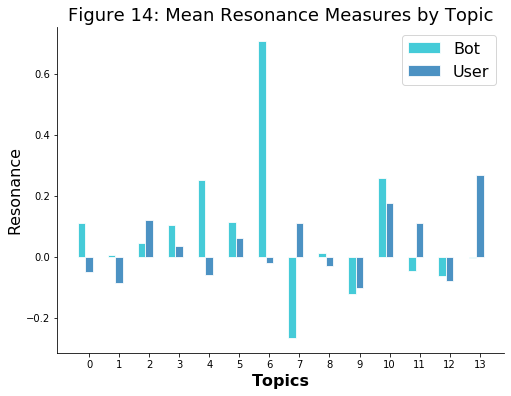

In [126]:
#create a barplot with the average resonance for each topic for each type of account
# set width of bar
barWidth = 0.25
 
# set heights of bar and max points
bot = mean_res[mean_res['type']=='bot']['Resonance']
user = mean_res[mean_res['type']=='user']['Resonance']
topics = mean_res.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(8,6))
 
# Make the plot
ax.bar(r1, bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Resonance', fontsize=16)
plt.title('Figure 14: Mean Resonance Measures by Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
#plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & save graphic
plt.legend(loc='best', fontsize=16)
plt.savefig("resonance_measures.png", format = 'png', bbox_inches='tight')

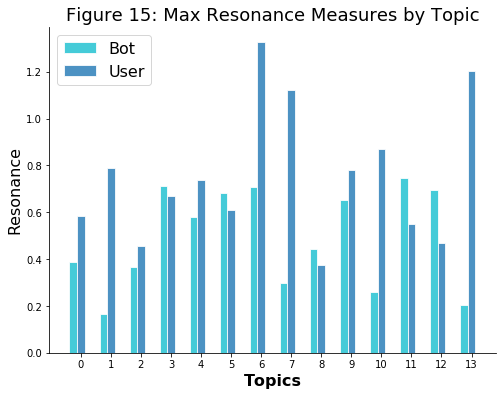

In [127]:
#create a barplot with the max resonance for each topic, for each type of account
# set width of bar
barWidth = 0.25
 
# set heights of bar and max points
max_bot = max_res[max_res['type']=='bot']['Max_Resonance']
max_user = max_res[max_res['type']=='user']['Max_Resonance']
topics = mean_res.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(max_bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(8,6))
 
# Make the plot
ax.bar(r1, max_bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, max_user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Resonance', fontsize=16)
plt.title('Figure 15: Max Resonance Measures by Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
#plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
plt.legend(loc='best', fontsize=16)
plt.savefig("resonance_measures.png", format = 'png', bbox_inches='tight')